In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from nansat import Nansat, Domain, NSR

from sea_ice_drift import get_n
from sea_ice_drift.ftlib import feature_tracking
from sea_ice_drift.pmlib import pattern_matching

%matplotlib inline

import os

In [3]:
# use original Sentinel-1 SAR files (download from colhub.met.no)
f1 = '/home/jovyan/work/icedrift/Nansen_algorithm/Data_and_output/SAR_safe/Mosaic_2020/S1B_EW_GRDM_1SDH_20200313T114854_20200313T114954_020673_027304_C177.SAFE'
f2 = '/home/jovyan/work/icedrift/Nansen_algorithm/Data_and_output/SAR_safe/Mosaic_2020/S1B_EW_GRDM_1SDH_20200314T105131_20200314T105231_020687_027372_2C73.SAFE'
'''
# create Nansat objects with one band only. 
n1 = get_n(f1, bandName='sigma0_HV')
n2 = get_n(f2, bandName='sigma0_HV')
'''
# use original Sentinel-1 SAR files (download from colhub.met.no)
f1 = '/home/jovyan/work/icedrift/Nansen_algorithm/Data_and_output/SAR_safe/Mosaic_2020/S1B_EW_GRDM_1SDH_20200313T114854_20200313T114954_020673_027304_C177.SAFE'
f2 = '/home/jovyan/work/icedrift/Nansen_algorithm/Data_and_output/SAR_safe/Mosaic_2020/S1B_EW_GRDM_1SDH_20200314T105131_20200314T105231_020687_027372_2C73.SAFE'
# create Nansat objects with one band only. 
#n1 = get_n(f1, bandName='sigma0_HH', remove_spatial_mean=True)
#n2 = get_n(f2, bandName='sigma0_HH', remove_spatial_mean=True)
#n1.export('/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/SAR_tiff_trial/get_n_HH_8b_db_WGS84_05resampling_spatial_mean.tif', driver='GTiff')

In [2]:
f1 = '/home/jovyan/work/icedrift/Nansen_algorithm/Data_and_output/SAR_safe/Mosaic_2020/S1B_EW_GRDM_1SDH_20200313T114854_20200313T114954_020673_027304_C177.SAFE'

In [ ]:
#export similar data for CIRFA algorithm input (it needs to be geotiff and projected to the metres projection)

In [3]:
from sea_ice_drift import get_uint8_image
#from sea_ice_drift import get_spatial_mean


#Export nansat objects to tif for the same input to CIRFA algorithm sa for nansen algorithm (Unit8 - 8 bit integer data type, but I think I don't need it 8)

#n1.export('S1B_EW_GRDM_1SDH_20200313T114854_20200313T114954_020673_027304_C177_n1_HH.tif', driver='GTiff')
#n2.export('S1B_EW_GRDM_1SDH_20200314T105131_20200314T105231_020687_027372_2C73_n2_HH.tif', driver='GTiff')


'''
#Example from Anton with db
n1 = Nansat(f1)
b1 = n1['sigma0_HH']
b1_db = 10 * np.log10(b1)
n2 = Nansat.from_domain(n1, b1_db)
n2.export('/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/SAR_tiff_trial/general_HH_32_db_WGS84_no_resampling.tif', driver='GTiff')

'''
srs1 = NSR(3996)


#Modified example from Anton to make it similar to get_n (I need with and without db, discuss with Jelte?)
n12 = Nansat(f1)

# projected coordinates of the first image corners
rows, cols = n12.shape()
n12x, n12y = n12.transform_points([0,cols,cols,0], [0,0,rows,rows], dst_srs=srs1)


#n12.resize(factor=0.5, resample_alg=-1) #Do I really need resampling for CIRFA - check how quicker it makes teh algorithm)
b12 = n12['sigma0_HH']
#b12[b12 <= 0] = np.nan
#b12 = 10 * np.log10(b12)
#b12 -= get_spatial_mean(b12) #do I need it? Do if it's applied in get_n for n1 and n2
#b12 = get_uint8_image(b12, vmin=None, vmax=None, pmin=10, pmax=99) #is it needed to make inpput data the same?
n12out = Nansat.from_domain(n12, b12)
# domain of interest with resolution 500 m for SAR image reprojection (-te - extent -tr  - resolution -ts - size
dom_sar12 = Domain(srs1.wkt, f'-te {n12x.min()} {n12y.min()} {n12x.max()} {n12y.max()} -tr 40 40')

n12out.reproject_gcps() #don't use any projection inside the brackets as it augtametically uses the best one for this area
n12out.vrt.tps = True 

n12out.reproject(dom_sar12) #n1.export

n12out.export('/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/SAR_tiff_trial/modified3_HH_32b_nodb_3996_noresampling_40m_13-03-2020.tif', driver='GTiff')


In [9]:
n12 = Nansat(f1)
b12 = n12['sigma0_HH']
n12out = Nansat.from_domain(n12, b12)


In [12]:
n12.transform_points?

Signature: n12.transform_points(colVector, rowVector, DstToSrc=0, dst_srs=None)
Docstring:
Transform given lists of X,Y coordinates into lon/lat or inverse

Parameters
-----------
colVector : lists
    X and Y coordinates in pixel/line or lon/lat  coordinate system
DstToSrc : 0 or 1

    - 0 - forward transform (pix/line => lon/lat)
    - 1 - inverse transformation

dst_srs : NSR
    destination spatial reference

Returns
--------
X, Y : lists
    X and Y coordinates in lon/lat or pixel/line coordinate system
File:      /opt/conda/lib/python3.10/site-packages/nansat/domain.py
Type:      method


In [10]:
gcp0 = n12out.vrt.dataset.GetGCPs()[0]
gcp0.GCPX

20.091404383861

In [118]:
# Run Feature Tracking
# get start/end coordinates in the image coordinate system (colums/rows)  
c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=20000, ratio_test=0.6)

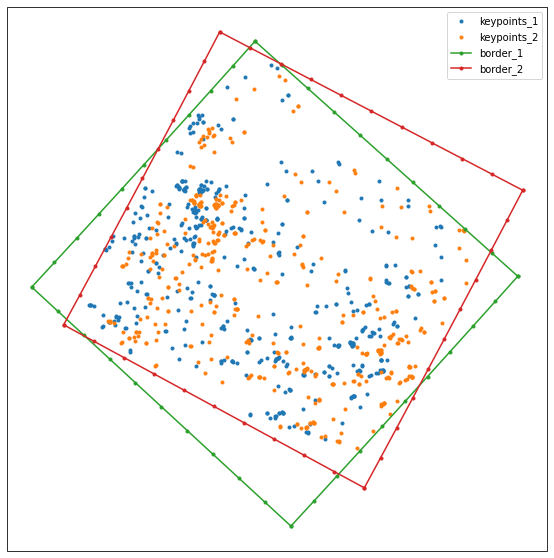

In [119]:
# Plot identified and matched keypoints in geographic coordinates

# convert row/column coordinates of matched features to lon/lat
lon1ft, lat1ft = n1.transform_points(c1, r1)
lon2ft, lat2ft = n2.transform_points(c2, r2)

# get lon/lat coordinates of the border of images
lon1b, lat1b = n1.get_border()
lon2b, lat2b = n2.get_border()


# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))
ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree())
ax.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree())
ax.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())
ax.legend()
plt.show()

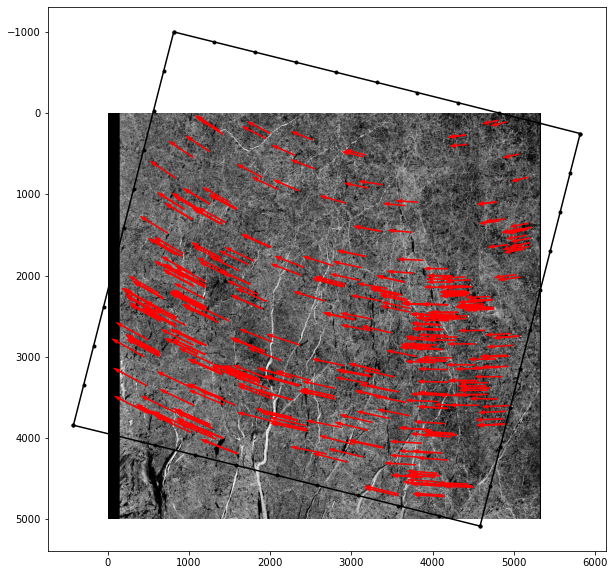

In [120]:
# Plot ice drift on top of image_1

# end points in image_1 coordinate system
n1c2, n1r2 = n1.transform_points(lon2ft, lat2ft, DstToSrc=1)

# ice drift components in image_1 coordinate system
dr = n1r2 - r1
dc = n1c2 - c1

# border of image_2 in image_1 coordinate system
n1lon2b, n1lat2b = n1.transform_points(lon2b, lat2b, DstToSrc=1)

# plot of ice drift. Arrows are 5 times longer than actual drift if scale=0.2
plt.figure(figsize=(10,10))
plt.imshow(n1[1], cmap='gray')
plt.quiver(c1, r1, dc, dr, color='r', angles='xy', scale_units='xy', scale=1)
plt.plot(n1lon2b, n1lat2b, 'k.-')
plt.show()

(86, 82)


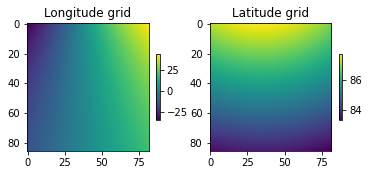

In [121]:
# Create lon/lat grids in Polar stereographic coordinate system 
# Extent of the grid roughly corresponds to the extent of the image_1

# projection (https://epsg.io/3413), I(Anna) often use this one https://epsg.io/3996 insted
srs = NSR(3996)

# projected coordinates of the first image corners
rows, cols = n1.shape()
n1x, n1y = n1.transform_points([0,cols,cols,0], [0,0,rows,rows], dst_srs=srs)

# domain of interest with resolution 5000 m
dom_pm = Domain(srs.wkt, f'-te {n1x.min()} {n1y.min()} {n1x.max()} {n1y.max()} -tr 5000 5000')
print(dom_pm.shape())

# lon/lat grids in polar stereographic projection covering image_1
lon1pm, lat1pm = dom_pm.get_geolocation_grids()
plt.subplot(1,2,1);plt.imshow(lon1pm);plt.colorbar(shrink=0.3);plt.title('Longitude grid')
plt.subplot(1,2,2);plt.imshow(lat1pm);plt.colorbar(shrink=0.3);plt.title('Latitude grid')
plt.show()

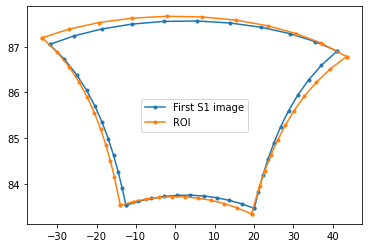

In [122]:
# plot coverage of the first S1 image and ROI
plt.plot(*n1.get_border(), '.-', label='First S1 image')
plt.plot(*dom_pm.get_border(), '.-', label='ROI')
plt.legend()
plt.show()

In [123]:
# Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Stereographic projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                          srs=srs.ExportToProj4())

/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide


/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide


99% 00433.7 03552.0 00291.0 04383.0 -03.0 0.54 12.73
 Pattern matching - OK! (  6 sec)


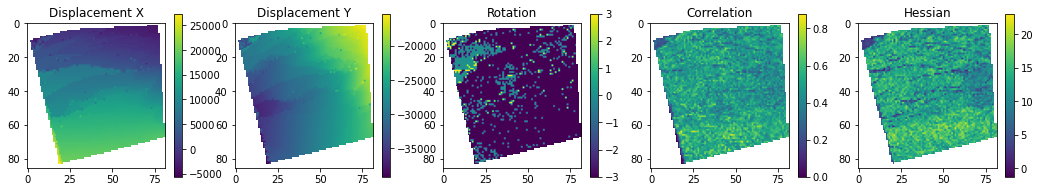

In [124]:
# plot retrieved matrices
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian']
fig, ax = plt.subplots(1,5, figsize=(18,3))
for i, a in enumerate([upm, vpm, apm, rpm, hpm]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a)
    plt.colorbar(im, ax=ax[i])

plt.show()

In [125]:
# image_1 in stereographic projection

# domain of interest with resolution 500 m for SAR image reprojection (-te - extent -tr  - resolution -ts - size
dom_sar = Domain(srs.wkt, f'-te {n1x.min()} {n1y.min()} {n1x.max()} {n1y.max()} -tr 500 500')
n1.reproject(dom_sar) #n1.export
n1b1pro = n1[1]
n1.undo()

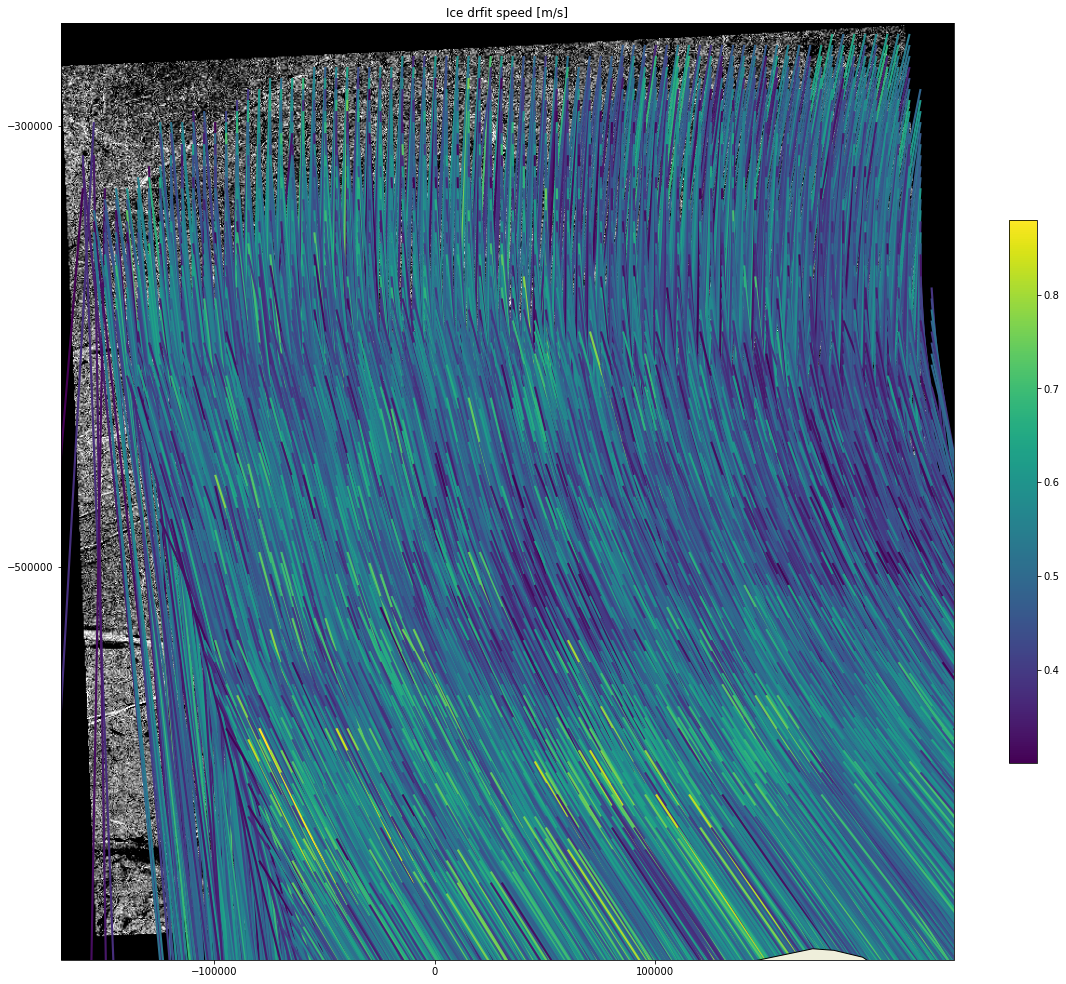

In [134]:
'''# compute ice drift speed [m/s]
delta_t = (n2.time_coverage_start - n1.time_coverage_start).total_seconds()
u = upm / delta_t
v = vpm / delta_t
'''
#compute displacement [m]
u = upm
v = vpm

# plot valid vectors in Polar stereographic projection
gpi = (rpm > 0.3) 
# X/Y grids in polar stereographic projection covering image_1
x1pm, y1pm = dom_pm.get_geolocation_grids(dst_srs=srs)

# spacial reference for plotting
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)

plt.figure(figsize=(20,20))
ax = plt.axes(projection=crs)

ax.imshow(n1b1pro, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv=ax.quiver(x1pm[gpi], y1pm[gpi], u[gpi], v[gpi], rpm[gpi], scale=1)
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
plt.show()

In [136]:
# export u/v componets into netcdf or geotiff file
n_out = Nansat.from_domain(dom_pm)
n_out.add_bands([u, v, apm, rpm, hpm], parameters=[{'name': 'u', 'units': 'm/s'}, {'name': 'v', 'units': 'm/s'}, {'name':'a', 'units': '_'}, {'name':'r','units': '_'}, {'name':'h','units': '_'}])
n_out.add_bands([u, v], parameters=[{'name': 'u', 'units': 'm/s'}, {'name': 'v', 'units': 'm/s'}])
#into netcdf 

#n_out.export('test_export_uv.nc')
# check exported file with ncdump
#!ncdump -h test_export_uv.nc

#into tiff

n_out.export('/home/jovyan/work/icedrift/Nansen_algorithm/Data_and_output/Nansen_output/13-14_march_2020/13-14_march_HH2.tif', driver='GTiff')

In [137]:
#check exported file with gdalinfo
#!gdalinfo /home/jovyan/work/icedrift/Nansen_algorithm/Data_and_output/Nansen_output/13-14_march_2020/13-14_march_HH.tif

In [93]:
# (Anna) Extracting the names of the input files 
path1, file1 = os.path.split(f1)
path2, file2 = os.path.split(f2)
filename1=file1[:-5]
filename2=file2[:-5]

print(filename1 ,filename2 )
print(path1)
print(f1)

S1B_EW_GRDM_1SDH_20200313T114854_20200313T114954_020673_027304_C177 S1B_EW_GRDM_1SDH_20200314T105131_20200314T105231_020687_027372_2C73
/home/jovyan/work/icedrift/Nansen_algorithm/Data_and_output/SAR_safe/Mosaic_2020
/home/jovyan/work/icedrift/Nansen_algorithm/Data_and_output/SAR_safe/Mosaic_2020/S1B_EW_GRDM_1SDH_20200313T114854_20200313T114954_020673_027304_C177.SAFE


In [104]:
n1 = Nansat(f1)
b1 = n1['sigma0_HV']
print(b1)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [128]:
#Export nansat objects to tif for the same input to CIRFA algorithm sa for nansen algorithm (Unit8 - 8 bit integer data type, but I think I don't need it 8)

n1.export('S1B_EW_GRDM_1SDH_20200313T114854_20200313T114954_020673_027304_C177_n1_HH.tif', driver='GTiff')
n2.export('S1B_EW_GRDM_1SDH_20200314T105131_20200314T105231_020687_027372_2C73_n2_HH.tif', driver='GTiff')


'''
#Example from Anton with db
n1 = Nansat(f1)
b1 = n1['sigma0_HV']
b1_db = 10 * np.log10(b1)
n2 = Nansat.from_domain(n1, b1_db)
n2.export('trial.tif', driver='GTiff')

'''
'''
#Example from Anton without db
n1 = Nansat(f1)
b1 = n1['sigma0_HV']
n2 = Nansat.from_domain(n1, b1)
n2.export('trial2.tif', driver='GTiff')
'''

'''
# export u/v componets into netcdf file
n_out = Nansat.from_domain(dom_pm)
n_out.add_bands([u, v], parameters=[{'name': 'u', 'units': 'm/s'}, {'name': 'v', 'units': 'm/s'}])
n_out.export('/home/jovyan/work/icedrift/Nansen_algorithm/trial_data/output/nersc_algorithm/13-14_march_2020/test_export_uv.nc')
'''


# check exported file with ncdump
#!ncdump -h test_export_uv.nc

#for tiff
#n_out.export('test_export_uv.tif', driver='GTiff')
#!gdalinfo test_export_uv.tif


"\n# export u/v componets into netcdf file\nn_out = Nansat.from_domain(dom_pm)\nn_out.add_bands([u, v], parameters=[{'name': 'u', 'units': 'm/s'}, {'name': 'v', 'units': 'm/s'}])\nn_out.export('/home/jovyan/work/icedrift/Nansen_algorithm/trial_data/output/nersc_algorithm/13-14_march_2020/test_export_uv.nc')\n"

In [ ]:
## Generate test files for simple.py
"""
filenames = [
    'S1B_EW_GRDM_1SDH_20200123T120618_20200123T120718_019944_025BA1_D4A2.SAFE',
    'S1B_EW_GRDM_1SDH_20200125T114955_20200125T115055_019973_025C81_EC1A.SAFE'
]
crop_params = [
    (1800,4400,1000,1000),
    (2400,4600,1000,1000),
]

for f,c in zip(filenames, crop_params): 
    n = Nansat(f)
    n.reproject_gcps()
    n.vrt.tps = True
    n.crop(*c)
    n.export(f[:32]+'.tif', bands=['sigma0_HV'], driver='GTiff')
#"""